## Cancer Detection with ML Models and Hyperparameter Tuning
**Bashini Mahaarachchi**

### Importing data and libraries

Importing required libraries

In [168]:
import numpy as np
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pylab as pl
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from scipy.stats import randint 
import seaborn as sns

Importing dataset and labels

In [169]:
with open('train.data') as train:
    cancer_data = [line.split(maxsplit=9999) for line in train]

cancer_data = pd.DataFrame(cancer_data)

In [170]:
with open('train.labels') as labels:
    cancer_data_labels = [line.split(maxsplit=1) for line in labels]

cancer_data_labels = pd.DataFrame(cancer_data_labels)

---
### Preprocessing data

In [171]:
cancer_data.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,71,0,95,0,538,404,20,0,0,...,255,570,86,0,36,0,80,0,0,524 \n
1,0,41,82,165,60,554,379,0,71,0,...,213,605,69,7,473,0,57,0,284,423 \n
2,0,0,1,40,0,451,402,0,0,0,...,235,593,28,0,24,0,90,0,34,508 \n
3,0,56,44,275,14,511,470,0,0,0,...,91,600,0,26,86,0,102,0,0,469 \n
4,105,0,141,348,0,268,329,0,0,1,...,813,0,0,0,0,190,301,0,0,354 \n


It can be seen that this '\n' appears in most of the rows in 10000th column. So I remove using regex. 

In [172]:
cancer_data[9999].replace(r'\s+|\\n', ' ', regex=True, inplace=True)

Now I convert the data type of the cancer dataset to 'int' since all the data we have are integers.

In [173]:
cancer_data = cancer_data.astype('int64')
cancer_data_labels = cancer_data_labels.astype('int64')

First I am going to see if the dataset has any missing values.

In [174]:
cancer_data.isnull().sum().sum()

0

In [175]:
cancer_data_labels.isnull().sum()

0    0
dtype: int64

We don't have any missing values in the dataset. So it is good to go.

Therefore, the features are non-descriptive and cannot derive any conclusions about how they relate to our target variable.

Also, it can be seen that the target attribute has 1 and -1 as labels, therefore i assume in class label "-1" implies that the patient is not detected as a cancer patient and "1" implies patient is a cancer patient.

The class values are recorded as '-1' and '1'. So I am going to replace '-1' to '0' for make it easier for the analysis.

In [176]:
cancer_data_labels.replace(-1,0, inplace =True)

In [177]:
cancer_data_labels.head()

,0
0,1
1,0
2,1
3,1
4,0


**Breakdown of patient information.**

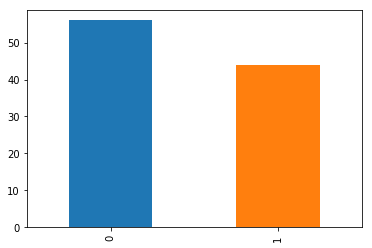

In [178]:
cancer_data_labels[0].value_counts().plot(kind='bar')

The dataset is complete without any missing values and it has nearly balanced class labels.

---
### Feature selection using backward elimination.

First I divide the data set in to training set and test sets, to make sure that any model I am going to develop will not be exposed to the test set - which will be used for evaluation purpos.

In [179]:
from sklearn.model_selection import train_test_split
X1_train,X1_test,Y1_train,Y1_test=train_test_split(cancer_data,cancer_data_labels,test_size=0.33,random_state=0)

In [180]:
X1_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
68,37,91,0,584,15,475,0,1,195,97,...,330,464,131,0,81,400,323,0,0,292
51,0,50,49,318,13,460,440,0,5,0,...,280,584,0,9,118,0,93,0,0,435
27,0,38,49,418,0,403,422,0,49,0,...,269,596,130,0,550,0,87,0,55,486
18,132,0,171,394,0,247,129,0,0,0,...,854,0,46,0,0,173,372,0,344,353
56,11,9,0,250,0,556,0,38,72,72,...,272,505,49,34,0,459,269,0,104,313


I keep the random state for the train test split at a constant value ("0") for all the analyses. So it is clear that all the tests are performed on the same data.

Now I am going to start performing backward elimination on the data set.

Backward elimination starts with all features contained in the dataset and removing  variables until an optimal model is found. 

To do that first I am going to use recursive feature elimination(RFE) method since it is the straight forward way provided in "Sklearn".

---
#### Using RFE for Backward Elimination

In [181]:
# Creating a base classifier used to evaluate a subset of attributes
model1 = LogisticRegression()
# Creating the RFE model and select 10 attributes
m1_rfe = RFE(model1, 10)
m1_rfe = m1_rfe.fit(X1_train, Y1_train)
# summarize the selection of the attributes
print(m1_rfe.support_)
print(m1_rfe.ranking_)

[False False False ... False  True False]
[4386 6457 6369 ... 9192    1 3376]


By using RFE method we can only get the ranking of the features and it selects features by looking at the co-efficients of the features. Therefore I am going to performed logistic regression on the features selected by the FRE and see it's statistics.

In [182]:
#Taking the attribute labels where ranking is one.
X1_train_cols = X1_train.columns.values
Rankings_list = m1_rfe.ranking_.tolist()
Rankings = np.array(Rankings_list)

#Taking the columns selected by RFE method
Selected_cols = [i for i,j in zip(X1_train_cols,Rankings) if j == 1]
Selected_Sample = X1_train[Selected_cols]

#Fitting a logistic regression of the above selected feature
Log_model_RFE = sm.Logit(Y1_train,sm.add_constant(Selected_Sample)).fit(method='bfgs',maxiter = 1000)
Log_model_RFE.summary()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 49
         Gradient evaluations: 49


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      0   No. Observations:                   67
Model:                          Logit   Df Residuals:                       56
Method:                           MLE   Df Model:                           10
Date:                Sun, 08 Sep 2019   Pseudo R-squ.:                   1.000
Time:                        16:21:49   Log-Likelihood:            -2.0893e-06
converged:                       True   LL-Null:                       -45.172
                                        LLR p-value:                 4.579e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6994   3.99e+05  -1.75e-06      1.000   -7.82e+05    7.82e+05
1183          -0.4551   1151.820     -0.000      1.000   -2257.981    2257.070
1918          -0.2241    783.981     -0.000      1.000   -1536.800    1536.351
3724           0.2397    833.003      0.000      1.000   -1632.417    1632.896
4541          -0.1970    721.888     -0.000      1.000   -1415.072    1414.678
7993          -0.1612   1592.260     -0.000      1.000   -3120.933    3120.611
8220           0.2259    733.648      0.000      1.000   -1437.697    1438.149
8467          -0.1977   4727.725  -4.18e-05      1.000   -9266.369    9265.973
8814          -0.1748   4813.611  -3.63e-05      1.000   -9434.679    9434.330
9251          -0.2030    460.066     -0.000      1.000    -901.916     901.510
9998          -0.1963    516.465     -0.000      1.000   -1012.450    1012.057
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

Now I am going to predict results for the test set using the above built model.

In [183]:
RFE_Predict = Log_model_RFE.predict(sm.add_constant(X1_test[Selected_cols]))

Before finding the accuracy of the model, I use 0.5 as the cutoff probability value to separate Predicted 'CANCER' and 'NON-CANCER' classes.

In [184]:
#Setting the probability values to binary
Y_pred_RFE = (RFE_Predict > 0.5).astype(int)

I am calculating the model accuracy and generate the classification report below.

In [185]:
print(accuracy_score(Y1_test,Y_pred_RFE))
print(classification_report(Y1_test,Y_pred_RFE))

0.7575757575757576
             precision    recall  f1-score   support

          0       0.70      0.88      0.78        16
          1       0.85      0.65      0.73        17

avg / total       0.78      0.76      0.75        33



As it can be seen from the summary of logistic regression none of the selected features were significant and there exists **Complete Separation** error. Accuracy of the model prediction is 0.75 and recall for 'CANCER'is comparatively low. Due to these reasons I am going to build a backward elimination process from the scratch.

---
#### Alternate Backward Elimination method

When trying to implement my own backward elimination process, the challenge was that there are 10,000 features from which I have to select the best features that classify the dataset correctly. It is not possible to fit a model with all 10,000 feature variables considering the computational power, it requires, therefore i followed the following steps in my analysis.

1.   I take a random sample of features ( which is not smaller than one third of the training sample ), then perform logistic regression between the chosen features and the corresponding labels.

2.   If the p-value of the chosen variable(s) are less than 0.1 (I tried doing the procedure for different p values less than 0.1) then I put them back in to the features set which was not selected before.

By repeating this method finally, I end up with a set of features which are less than one third of the training sample. *(Note that I have chosen the final number of features to be less than one third of the training sample size to avoid overfitting)*


When selecting the features, I removed the features with p value equal to 0.0, which gives the **"perfectseperation"** error. 
Such features perfectly classify the actual labels without the need to have a model to classify. When I looked at the values of these features, there are values available in only few instances of the samples. Thus they don't necessarily mean they are good features to classify the dataset. *(i.e. Does not generalize over every sample in that target attribute class)*

I used **logistic regression** since it is the most commonly used binary classification method.

In logistic regression we hypothesize(null hypothesis) that the independent variable(s) (here we can't say directly all feature variables are independent) used are insignificant for predicting the dependent variable (classifier variable) or in simpler terms their coefficient will be 0. But if we get a P-value lesser than 5% we conclude that the variable is significant and thus reject our null hypothesis in favor of alternate hypothesis. Therefore, smaller the P-value more significant is that variable for your logistic regression model.

in *logistic regression* it is possible that the Hessian is not positive definite when we evaluate it far away from the optimum. This is due to the Statsmodels logistic model's inability to find a maximum of the loglikelihood function, for example at bad starting values. Switching to an optimizer that does not use the Hessian often succeeds in those cases. Here I used scipy's 'bfgs' optimizer.

Method BFGS uses the quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno (BFGS). It uses the first derivatives only.

Following is the function I used to find the best features set out of 10,000 features

In [186]:
def Backward_Eli(y_train,x_train):
  
    np.random.seed(10)
    new_train = x_train.copy()
    COUNT = 0
  
    while len(new_train.columns)>0:
        if (len(new_train.columns)) <= np.round(x_train.shape[0]/3).astype('int'):
            print('Final sample too small!')
            break
      
        train_sample = new_train.sample(n=np.round(x_train.shape[0]/3).astype('int'),axis=1)
        train_sample_w_cons = sm.add_constant(train_sample)
        train_remaning = new_train.drop(train_sample.columns,axis=1)
    
        sample_mod = sm.Logit(Y1_train,train_sample_w_cons).fit(method='bfgs',maxiter = 1000)
        selected_idx_li = sample_mod.pvalues[(sample_mod.pvalues.index.isin(train_sample.columns.values)) & (sample_mod.pvalues < 0.1) & (sample_mod.pvalues > 0.0)].index

        train_sample_sel = train_sample[selected_idx_li]
        new_train = pd.concat([train_sample_sel,train_remaning],axis=1)
    
        COUNT += 1
    
        print((COUNT, len(new_train.columns)))
    
        if len(selected_idx_li)== np.round(x_train.shape[0]/3).astype('int'):
            print('Perfect training sample')
            new_train = train_sample_sel
    return new_train

In [187]:
new_ft_set = Backward_Eli(Y1_train,X1_train)

Optimization terminated successfully.
         Current function value: 0.289736
         Iterations: 88
         Function evaluations: 98
         Gradient evaluations: 92
(1, 9985)
Optimization terminated successfully.
         Current function value: 0.421784
         Iterations: 53
         Function evaluations: 60
         Gradient evaluations: 60
(2, 9963)
Optimization terminated successfully.
         Current function value: 0.310407
         Iterations: 90
         Function evaluations: 97
         Gradient evaluations: 97
(3, 9946)
Optimization terminated successfully.
         Current function value: 0.237607
         Iterations: 96
         Function evaluations: 107
         Gradient evaluations: 103
(4, 9931)
Optimization terminated successfully.
         Current function value: 0.343167
         Iterations: 68
         Function evaluations: 81
         Gradient evaluations: 76
(5, 9917)
Optimization terminated successfully.
         Current function value: 0.000000
        

(49, 9081)
Optimization terminated successfully.
         Current function value: 0.167818
         Iterations: 151
         Function evaluations: 158
         Gradient evaluations: 158
(50, 9059)
Optimization terminated successfully.
         Current function value: 0.343826
         Iterations: 59
         Function evaluations: 69
         Gradient evaluations: 65
(51, 9045)
Optimization terminated successfully.
         Current function value: 0.255394
         Iterations: 84
         Function evaluations: 94
         Gradient evaluations: 90
(52, 9026)
Optimization terminated successfully.
         Current function value: 0.183524
         Iterations: 112
         Function evaluations: 122
         Gradient evaluations: 117
(53, 9009)
Optimization terminated successfully.
         Current function value: 0.386500
         Iterations: 61
         Function evaluations: 69
         Gradient evaluations: 69
(54, 8991)
Optimization terminated successfully.
         Current function valu

(96, 8215)
Optimization terminated successfully.
         Current function value: 0.397026
         Iterations: 89
         Function evaluations: 98
         Gradient evaluations: 94
(97, 8196)
Optimization terminated successfully.
         Current function value: 0.306085
         Iterations: 64
         Function evaluations: 72
         Gradient evaluations: 72
(98, 8182)
Optimization terminated successfully.
         Current function value: 0.256402
         Iterations: 78
         Function evaluations: 83
         Gradient evaluations: 83
(99, 8165)
Optimization terminated successfully.
         Current function value: 0.287291
         Iterations: 60
         Function evaluations: 68
         Gradient evaluations: 68
(100, 8150)
Optimization terminated successfully.
         Current function value: 0.369758
         Iterations: 55
         Function evaluations: 67
         Gradient evaluations: 62
(101, 8130)
Optimization terminated successfully.
         Current function value: 0

Optimization terminated successfully.
         Current function value: 0.316302
         Iterations: 74
         Function evaluations: 79
         Gradient evaluations: 79
(143, 7312)
Optimization terminated successfully.
         Current function value: 0.404158
         Iterations: 89
         Function evaluations: 98
         Gradient evaluations: 98
(144, 7290)
Optimization terminated successfully.
         Current function value: 0.325378
         Iterations: 97
         Function evaluations: 109
         Gradient evaluations: 104
(145, 7272)
Optimization terminated successfully.
         Current function value: 0.352830
         Iterations: 60
         Function evaluations: 73
         Gradient evaluations: 69
(146, 7256)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 65
         Gradient evaluations: 57
(147, 7234)
Optimization terminated successfully.
         Current function value: 0.30521

(188, 6450)
Optimization terminated successfully.
         Current function value: 0.430101
         Iterations: 42
         Function evaluations: 49
         Gradient evaluations: 49
(189, 6428)
Optimization terminated successfully.
         Current function value: 0.251703
         Iterations: 117
         Function evaluations: 124
         Gradient evaluations: 124
(190, 6413)
Optimization terminated successfully.
         Current function value: 0.439874
         Iterations: 48
         Function evaluations: 62
         Gradient evaluations: 58
(191, 6393)
Optimization terminated successfully.
         Current function value: 0.264070
         Iterations: 69
         Function evaluations: 79
         Gradient evaluations: 75
(192, 6377)
Optimization terminated successfully.
         Current function value: 0.228894
         Iterations: 91
         Function evaluations: 100
         Gradient evaluations: 96
(193, 6362)
Optimization terminated successfully.
         Current function 

Optimization terminated successfully.
         Current function value: 0.313351
         Iterations: 69
         Function evaluations: 83
         Gradient evaluations: 78
(237, 5548)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 62
         Gradient evaluations: 57
(238, 5526)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 121
         Function evaluations: 132
         Gradient evaluations: 128
(239, 5504)
Optimization terminated successfully.
         Current function value: 0.210407
         Iterations: 124
         Function evaluations: 136
         Gradient evaluations: 132
(240, 5482)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 102
         Function evaluations: 107
         Gradient evaluations: 107
(241, 5460)
Optimization terminated successfully.
         Current function value: 

         Gradient evaluations: 71
(281, 4678)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 113
         Function evaluations: 127
         Gradient evaluations: 123
(282, 4656)
Optimization terminated successfully.
         Current function value: 0.347591
         Iterations: 107
         Function evaluations: 120
         Gradient evaluations: 115
(283, 4639)
Optimization terminated successfully.
         Current function value: 0.217405
         Iterations: 115
         Function evaluations: 122
         Gradient evaluations: 122
(284, 4619)
Optimization terminated successfully.
         Current function value: 0.380120
         Iterations: 57
         Function evaluations: 69
         Gradient evaluations: 64
(285, 4601)
Optimization terminated successfully.
         Current function value: 0.283255
         Iterations: 84
         Function evaluations: 97
         Gradient evaluations: 93
(286, 4583)
Optimization terminated s

(326, 3787)
Optimization terminated successfully.
         Current function value: 0.192558
         Iterations: 103
         Function evaluations: 114
         Gradient evaluations: 110
(327, 3770)
Optimization terminated successfully.
         Current function value: 0.289879
         Iterations: 72
         Function evaluations: 79
         Gradient evaluations: 79
(328, 3755)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 59
         Function evaluations: 68
         Gradient evaluations: 68
(329, 3733)
Optimization terminated successfully.
         Current function value: 0.443568
         Iterations: 47
         Function evaluations: 60
         Gradient evaluations: 55
(330, 3711)
Optimization terminated successfully.
         Current function value: 0.127033
         Iterations: 127
         Function evaluations: 138
         Gradient evaluations: 133
(331, 3689)
Optimization terminated successfully.
         Current functio

         Iterations: 64
         Function evaluations: 71
         Gradient evaluations: 71
(372, 2912)
Optimization terminated successfully.
         Current function value: 0.249481
         Iterations: 86
         Function evaluations: 97
         Gradient evaluations: 93
(373, 2896)
Optimization terminated successfully.
         Current function value: 0.311277
         Iterations: 90
         Function evaluations: 99
         Gradient evaluations: 99
(374, 2883)
Optimization terminated successfully.
         Current function value: 0.202886
         Iterations: 91
         Function evaluations: 97
         Gradient evaluations: 97
(375, 2868)
Optimization terminated successfully.
         Current function value: 0.257236
         Iterations: 81
         Function evaluations: 94
         Gradient evaluations: 90
(376, 2846)
Optimization terminated successfully.
         Current function value: 0.226530
         Iterations: 86
         Function evaluations: 100
         Gradient eva

(416, 2079)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 62
         Gradient evaluations: 62
(417, 2057)
Optimization terminated successfully.
         Current function value: 0.191020
         Iterations: 101
         Function evaluations: 109
         Gradient evaluations: 109
(418, 2035)
Optimization terminated successfully.
         Current function value: 0.358753
         Iterations: 70
         Function evaluations: 80
         Gradient evaluations: 76
(419, 2018)
Optimization terminated successfully.
         Current function value: 0.401511
         Iterations: 79
         Function evaluations: 84
         Gradient evaluations: 84
(420, 1997)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 96
         Function evaluations: 101
         Gradient evaluations: 101
(421, 1975)
Optimization terminated successfully.
         Current function

(462, 1149)
Optimization terminated successfully.
         Current function value: 0.262711
         Iterations: 66
         Function evaluations: 72
         Gradient evaluations: 72
(463, 1131)
Optimization terminated successfully.
         Current function value: 0.338574
         Iterations: 84
         Function evaluations: 97
         Gradient evaluations: 93
(464, 1113)
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 76
         Function evaluations: 83
         Gradient evaluations: 83
(465, 1091)
Optimization terminated successfully.
         Current function value: 0.414929
         Iterations: 47
         Function evaluations: 54
         Gradient evaluations: 54
(466, 1073)
         Current function value: 0.000000
         Iterations: 172
         Function evaluations: 199
         Gradient evaluations: 183
(467, 1051)
Optimization terminated successfully.
         Current function value: 0.309982
         Iterations: 10

(509, 212)
Optimization terminated successfully.
         Current function value: 0.327131
         Iterations: 61
         Function evaluations: 68
         Gradient evaluations: 68
(510, 190)
Optimization terminated successfully.
         Current function value: 0.186722
         Iterations: 136
         Function evaluations: 142
         Gradient evaluations: 142
(511, 171)
Optimization terminated successfully.
         Current function value: 0.388973
         Iterations: 53
         Function evaluations: 64
         Gradient evaluations: 60
(512, 154)
Optimization terminated successfully.
         Current function value: 0.119559
         Iterations: 162
         Function evaluations: 181
         Gradient evaluations: 174
(513, 134)
Optimization terminated successfully.
         Current function value: 0.295339
         Iterations: 76
         Function evaluations: 85
         Gradient evaluations: 81
(514, 112)
Optimization terminated successfully.
         Current function valu

Above implemented backward elimination process results with the below set of (best) feature attributes.

In [188]:
new_ft_set.head()

,9361,6058,944,7325,9405,108,9289,8607,196,4279,5941,7570
68,102,0,15,372,161,128,62,0,0,0,0,219
51,0,0,0,9,55,0,0,167,11,304,0,0
27,39,0,0,0,56,0,44,150,0,304,0,80
18,14,0,0,422,14,0,0,120,0,125,0,7
56,117,0,0,240,40,106,70,0,19,0,0,86


Now I am going to fit a logistic regression for the features selected by alternate backward elimination.

In [189]:
Log_model = sm.Logit(Y1_train,sm.add_constant(new_ft_set)).fit(method='bfgs',maxiter = 1000)
Log_model.summary()

Optimization terminated successfully.
         Current function value: 0.325177
         Iterations: 45
         Function evaluations: 49
         Gradient evaluations: 49


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      0   No. Observations:                   67
Model:                          Logit   Df Residuals:                       54
Method:                           MLE   Df Model:                           12
Date:                Sun, 08 Sep 2019   Pseudo R-squ.:                  0.5177
Time:                        16:22:13   Log-Likelihood:                -21.787
converged:                       True   LL-Null:                       -45.172
                                        LLR p-value:                 5.110e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4423      2.315     -0.623      0.533      -5.980       3.096
9361           0.0434      0.018      2.410      0.016       0.008       0.079
6058          -0.4664      0.234     -1.997      0.046      -0.924      -0.009
944            0.2264      0.118      1.920      0.055      -0.005       0.458
7325          -0.0020      0.003     -0.715      0.475      -0.007       0.003
9405           0.0312      0.020      1.597      0.110      -0.007       0.070
108           -0.0422      0.021     -2.021      0.043      -0.083      -0.001
9289           0.0017      0.016      0.108      0.914      -0.030       0.033
8607          -0.0092      0.014     -0.675      0.500      -0.036       0.018
196           -0.0829      0.056     -1.481      0.139      -0.193       0.027
4279           0.0079      0.009      0.863      0.388      -0.010       0.026
5941          -0.0103      0.082     -0.125      0.900      -0.172       0.151
7570          -0.0186      0.016     -1.145      0.252      -0.051       0.013
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Still P-value of most of the features are considerably large. But since this is the best random selection of features (Better than what we got from RFE method above) found from the algorithm, I am going to predict the test results from the above built model.

In [190]:
#Taking the column values of best features.
best_ft = new_ft_set.columns

In [191]:
#Predicting the test values by the logistic model built above
XL_test = X1_test[best_ft]
YL_predict = Log_model.predict(sm.add_constant(XL_test),)

Before finding the accuracy of the model, to decide on the cut-off probability threshold value for the prediction for cancer vs non-cancer patients *(value which can control true and false predictions)*, The optimal cut-off point would be where true positive rate is high and the false positive rate is low in other words where true prositive rate and true negative tare is maximum. Based on this logic, I am going to find optimal threshold.

In [192]:
def Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Finding the optimal probability threshold for the predicted y values
threshold = Optimal_Cutoff(Y1_test, YL_predict)
print (threshold)


def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

[0.2962897381783918]


Now I am using the threshold probability value to separate Predicted 'CANCER' and 'NON-CANCER' classes.

In [193]:
#Setting the probability values to binary
Y_predict = (YL_predict > 0.2962897381783918).astype(int)

Now I am going to find the AUC for new predicted model.

In [194]:
roc_auc_score(Y1_test,YL_predict)

0.8014705882352942

Now I am going to take the classification report and the accuracy score for the final model.

In [195]:
print(accuracy_score(Y1_test,Y_predict ))
print(classification_report(Y1_test,Y_predict))

0.696969696969697
             precision    recall  f1-score   support

          0       0.67      0.75      0.71        16
          1       0.73      0.65      0.69        17

avg / total       0.70      0.70      0.70        33



In this study  **it is particularly important to
ensure that no cancer remains undetected**. Therefore, I tuned the algorithm so that prediction has maximum recall for class "label 1".

Problem with this method is that, the final features set is highly dependent on the ***random state*** used for train test split and also in selecting the features in the recursive process.

Thus this approach lacks reproduicibility of  the results. (i.e when different random states are used final features set is different from one random sate to the other)

---
### Classify using Principal Component Analysis (PCA) and Logistic Regression

Now I am going to apply PCA (Principal Component Analysis) to select best features.

When the learning algorithm is too slow because the input dimension is too high, then using PCA to speed it up can be a reasonable choice.


Desired goal of PCA is to reduce the dimensions of a d-dimensional dataset by projecting it onto a (k)-dimensional subspace (where k<<d) in order to increase the computational efficiency while retaining most of the information.

I am going to perform PCA using Python's Scikit-Learn library. The PCA class is used for this purpose. PCA depends only upon the feature set and not the label data. Therefore, PCA can be considered as an unsupervised machine learning technique.

Performing PCA using Scikit-Learn is a two-step process:

1.   Initialize the PCA class by passing the number of components to the constructor.

2.   Call the fit and then transform methods by passing the feature set to these methods. The transform method returns the specified number of principal components.

Before applying PCA I normalize data since PCA is a variance maximizing exercise. It projects original data onto directions which maximize the variance. 
So for finding features usable for any kind of model, a PCA without normalization would calculate variance biased towards one variable.

In [196]:
minmax = MinMaxScaler()
cancer_data_n = minmax.fit_transform(cancer_data)

In [197]:
pd.DataFrame(cancer_data_n).head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.000000,0.325688,0.000000,0.104615,0.000000,0.888060,0.819473,0.363636,0.000000,0.000000,...,0.241895,0.871560,0.441026,0.000000,0.054878,0.000000,0.102362,0.0,0.000000,0.983114
1,0.000000,0.188073,0.347458,0.212308,0.606061,0.927861,0.768763,0.000000,0.351485,0.000000,...,0.189526,0.925076,0.353846,0.084337,0.721037,0.000000,0.041995,0.0,0.724490,0.793621
2,0.000000,0.000000,0.004237,0.020000,0.000000,0.671642,0.815416,0.000000,0.000000,0.000000,...,0.216958,0.906728,0.143590,0.000000,0.036585,0.000000,0.128609,0.0,0.086735,0.953096
3,0.000000,0.256881,0.186441,0.381538,0.141414,0.820896,0.953347,0.000000,0.000000,0.000000,...,0.037406,0.917431,0.000000,0.313253,0.131098,0.000000,0.160105,0.0,0.000000,0.879925
4,0.558511,0.000000,0.597458,0.493846,0.000000,0.216418,0.667343,0.000000,0.000000,0.002558,...,0.937656,0.000000,0.000000,0.000000,0.000000,0.391753,0.682415,0.0,0.000000,0.664165


Now I divide the data in to training set and test set to the same proportion used before and using the same random state.

In [198]:
X_train,X_test,Y_train,Y_test=train_test_split(cancer_data_n,cancer_data_labels,test_size=0.33,random_state=0)

Now I perform PCA on the normalized data. In the following code I am creating a PCA object named pca. I do not specify the number of components in the constructor. Hence, all of the features in the feature set will be returned for both the training and test sets.

In [199]:
pca = PCA()
PC_X_train = pca.fit_transform(X_train)
PC_X_test = pca.transform(X_test)

In [200]:
PC_X_train = pd.DataFrame(PC_X_train)

PCA class contains **explained_variance_ratio_** which returns the variance caused (variance explains) by each of the principal components.

[3.29372759e-01 1.19490214e-01 6.95339334e-02 3.82996558e-02
 3.74167122e-02 3.09660650e-02 2.46051663e-02 2.05396011e-02
 1.63900485e-02 1.44787075e-02 1.22647918e-02 1.08537910e-02
 1.04787696e-02 9.13237198e-03 8.84661577e-03 8.57672705e-03
 8.33460631e-03 8.09392661e-03 7.92127325e-03 7.36084115e-03
 7.24172761e-03 6.89017271e-03 6.66305258e-03 6.58599473e-03
 6.38957563e-03 6.20243554e-03 6.16652289e-03 5.88532595e-03
 5.61976016e-03 5.58746289e-03 5.32772568e-03 5.28090188e-03
 5.09444646e-03 5.06025827e-03 4.98620151e-03 4.90276108e-03
 4.77866726e-03 4.71340932e-03 4.52407018e-03 4.50644555e-03
 4.46767160e-03 4.39694679e-03 4.34335953e-03 4.19035093e-03
 4.17160532e-03 4.08114710e-03 4.03840030e-03 4.00259587e-03
 3.90370114e-03 3.86057345e-03 3.79684488e-03 3.71216363e-03
 3.63264920e-03 3.59684635e-03 3.49066746e-03 3.48398188e-03
 3.40314744e-03 3.38887999e-03 3.30610870e-03 3.23909184e-03
 3.17254518e-03 3.13666403e-03 3.07401173e-03 2.98587668e-03
 2.93471243e-03 2.825961

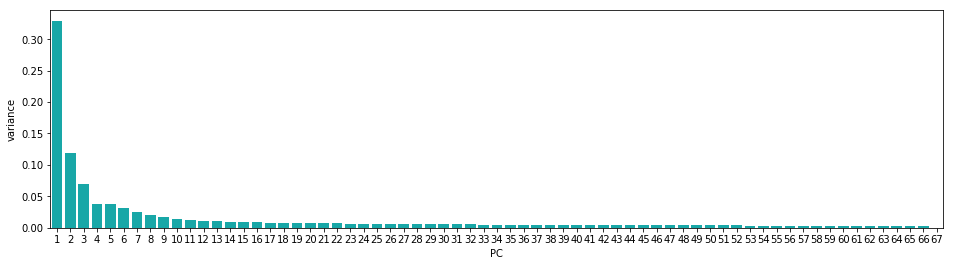

In [201]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
scree = pd.DataFrame({'variance':pca.explained_variance_ratio_,'PC':np.arange(1,68,1)})
plt.figure(figsize=(16, 4))
sns.barplot(x='PC',y="variance", data=scree, color="c");

It can be seen that first principal component is responsible for 32.93% variance. Similarly, the second principal component covers 11.94% and the 3rd PC captures 6.95% variance in the dataset and so on.

Next I fit a logistic regression on the PCAs generated

In [202]:
L_model = sm.Logit(Y_train,sm.add_constant(PC_X_train.values)).fit(method='bfgs',maxiter = 1000)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27


In [203]:
Y1_pred = L_model.predict(sm.add_constant(PC_X_test),)
Y1_pred = pd.DataFrame(Y1_pred)

Similar to above model, here I find the threshold probability of the predicted classes which true positive rate is high and the false positive rate is low.

In [204]:
def Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])


# Finding the optimal probability threshold for the predicted y values
threshold = Optimal_Cutoff(Y_test.values, Y1_pred)
print (threshold)

[0.08379129449956968]


In [205]:
#Setting the probability values to binary
Y2_pred = (Y1_pred > 0.08379129449956968).astype(int)

Following is the classification report and accuracy of the new logistic regression model fit using the PCAs.

In [206]:
print(accuracy_score(Y_test.values,Y2_pred))
print(classification_report(Y_test.values,Y2_pred))

0.8787878787878788
             precision    recall  f1-score   support

          0       0.83      0.94      0.88        16
          1       0.93      0.82      0.87        17

avg / total       0.88      0.88      0.88        33



It can be seen that accuracy and the recall of Cancer Positive label has significantly improved in this model.

To visualize this results, I am going to draw a plot which shows the correctly classified and misclassified labels for the 1st 4 principle components.

In [207]:
Y_test.reset_index()[0]
plot_df = pd.DataFrame({'True_val': Y_test.reset_index()[0], 
                        'Predicted': Y2_pred.reset_index()[0], 
                        'PC1': PC_X_test[:,0].tolist(), 
                        'PC2' : PC_X_test[:,1].tolist(),
                        'PC3' : PC_X_test[:,2].tolist(),
                        'PC4' : PC_X_test[:,3].tolist(),})

In [208]:
class_compare = [None] * len(Y2_pred)

for i in range(0,len(plot_df)):
    if plot_df.Predicted[i] == plot_df.True_val[i]:
        if plot_df.True_val[i] == 1:
            class_compare[i] = 'correct 1'
        if plot_df.True_val[i] == 0:
            class_compare[i] = 'correct 0'
    elif plot_df.True_val[i] == 1 and plot_df.Predicted[i] == 0:
        class_compare[i] = 'misclassified fn'
    elif plot_df.True_val[i] == 0 and plot_df.Predicted[i] == 1:
        class_compare[i] = 'misclassified fp'
plot_df['result']= class_compare

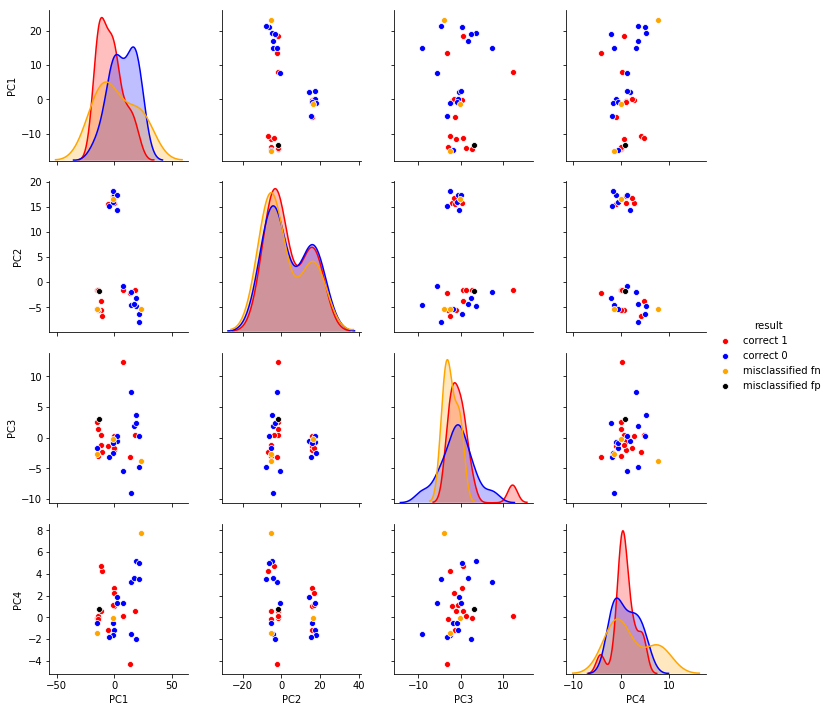

In [209]:
sns.pairplot(data=plot_df,hue='result',vars=['PC1','PC2','PC3','PC4'], palette= ['red','blue','orange','black'])

By looking at the above plots it can be said that there is a somewhat clear separtion between the cancer positive and cancer negative classes only between the 1st and the 2nd PCs.

---
### Classify using Principal Component Analysis (PCA) and Random Forest

To see if a better model than the previous one can be fit to classify the data, I am going to run PCA on data and then fit a Random forest.

First I use 1 principal component to train the algorithm.

In [210]:
pca = PCA(n_components=1)
FPC_X_train = pca.fit_transform(X_train)
FPC_X_test = pca.transform(X_test)

Now I am going to use random forest classification for making the predictions.

In [211]:
classifier = RandomForestClassifier(max_depth=2, random_state=8)
classifier.fit(FPC_X_train, Y_train)

# Predicting the Test set results
y3_predict = classifier.predict(FPC_X_test)
y3_predict = y3_predict.astype(int)

Evaluating the performance

In [212]:
cm = confusion_matrix(Y_test, y3_predict)
print(cm)
print(f'Accuracy {accuracy_score(Y_test, y3_predict)}')
print(f'AUC {classification_report(Y_test,y3_predict)}')

[[12  4]
 [ 8  9]]
Accuracy 0.6363636363636364
AUC              precision    recall  f1-score   support

          0       0.60      0.75      0.67        16
          1       0.69      0.53      0.60        17

avg / total       0.65      0.64      0.63        33



It can be seen from the output that with only one feature, the random forest algorithm is able to correctly predict 21 out of 33 instances, resulting in 63.63% accuracy.

Now I am going to find out how many PCs account for 90% of the total variance if the full model is considered.

In [213]:
pca = PCA()
F1PC_X_train = pca.fit_transform(X_train)
F1PC_X_test = pca.transform(X_test)

[3.29372759e-01 1.19490214e-01 6.95339334e-02 3.82996558e-02
 3.74167122e-02 3.09660650e-02 2.46051663e-02 2.05396011e-02
 1.63900485e-02 1.44787075e-02 1.22647918e-02 1.08537910e-02
 1.04787696e-02 9.13237198e-03 8.84661577e-03 8.57672705e-03
 8.33460631e-03 8.09392661e-03 7.92127325e-03 7.36084115e-03
 7.24172761e-03 6.89017271e-03 6.66305258e-03 6.58599473e-03
 6.38957563e-03 6.20243554e-03 6.16652289e-03 5.88532595e-03
 5.61976016e-03 5.58746289e-03 5.32772568e-03 5.28090188e-03
 5.09444646e-03 5.06025827e-03 4.98620151e-03 4.90276108e-03
 4.77866726e-03 4.71340932e-03 4.52407018e-03 4.50644555e-03
 4.46767160e-03 4.39694679e-03 4.34335953e-03 4.19035093e-03
 4.17160532e-03 4.08114710e-03 4.03840030e-03 4.00259587e-03
 3.90370114e-03 3.86057345e-03 3.79684488e-03 3.71216363e-03
 3.63264920e-03 3.59684635e-03 3.49066746e-03 3.48398188e-03
 3.40314744e-03 3.38887999e-03 3.30610870e-03 3.23909184e-03
 3.17254518e-03 3.13666403e-03 3.07401173e-03 2.98587668e-03
 2.93471243e-03 2.825961

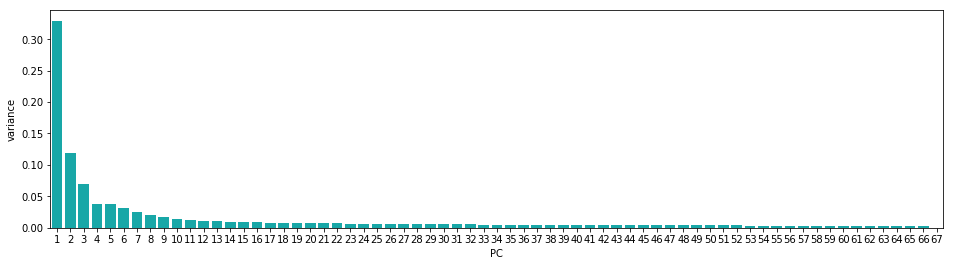

In [214]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
scree2 = pd.DataFrame({'variance':pca.explained_variance_ratio_,'PC':np.arange(1,68,1)})
plt.figure(figsize=(16, 4))
sns.barplot(x='PC',y="variance", data=scree2, color="c");

In [215]:
total =0
for ele in range(0, len(explained_variance)):
    total = total + explained_variance[ele]
    if total > 0.9:
        print("Number of features that account for 90% of the variance: ", ele) 
        break

Number of features that account for 90% of the variance:  38


Since 38 features account for 90% of the variance I am going to add only the first 38 features to the algorithm and see if the performance improves.

In [216]:
pca = PCA(n_components=38)
F2PC_X_train = pca.fit_transform(X_train)
F2PC_X_test = pca.transform(X_test)

In [217]:
classifier = RandomForestClassifier(random_state=3)

classifier.fit(F2PC_X_train, Y_train)

# Predicting the Test set results
y4_predict = classifier.predict(F2PC_X_test)
y4_predict = y4_predict.astype(int)

cm = confusion_matrix(Y_test, y4_predict)

Now I am going to generate the classification report, confusion matrix and accuracy for the new model built using 38 PCs.

In [218]:
print(classification_report(Y_test,y4_predict))
print(cm)
print(accuracy_score(Y_test, y4_predict))

             precision    recall  f1-score   support

          0       0.67      1.00      0.80        16
          1       1.00      0.53      0.69        17

avg / total       0.84      0.76      0.74        33

[[16  0]
 [ 8  9]]
0.7575757575757576


Model accuracy and other model evaluation parameters have become better when the RandomForest is fit for the 38 features that explains the variance mostly.

Using the results obtained above, in order to see if it's possible to construct a better mode, now I am going to use **gridsearchcv** to find the best hyper parameter settings to the algorithm.

---
#### Using Gridsearchcv to find the hyperparameter setting for the RandomForest classifier .

In [219]:
# Creating the hyperparameter grid
param_dic = { "n_estimators": np.arange(10,20,1),
                "max_depth": np.arange(1,7,1), 
                "max_features": np.arange(1,38,1), 
                "min_samples_leaf":np.arange(1,5,1)} 
  
# Instantiating Decision Tree classifier 
Rnd_forest = RandomForestClassifier()
  
# Instantiating GridSearchCV object 
forest_cv = GridSearchCV(Rnd_forest, param_dic, cv = 5)
  
forest_cv.fit(F2PC_X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'max_depth': array([1, 2, 3, 4, 5, 6]), 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37]), 'min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [220]:
# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(forest_cv.best_estimator_)) 
print("Best score is {}".format(forest_cv.best_score_)) 

Tuned Decision Tree Parameters: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=19, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best score is 0.7910447761194029


Now I am going to fit a model for the trained model using Gridsearch.

In [221]:
y5_predict = forest_cv.predict(F2PC_X_test)
cm3 = confusion_matrix(Y_test, y5_predict)
print(cm3)
print(accuracy_score(Y_test, y5_predict))
print(classification_report(Y_test,y5_predict ))

[[13  3]
 [ 1 16]]
0.8787878787878788
             precision    recall  f1-score   support

          0       0.93      0.81      0.87        16
          1       0.84      0.94      0.89        17

avg / total       0.88      0.88      0.88        33



As it can be seen above I have the model with best performance so far. In this study  **it is particularly important to
ensure that no cancer remains undetected**. And final model fulfils that requirement by having a higher **recall** for **Positives**.

To visualize these results, I am again going to draw a plot which shows the correctly classified and misclassified labels for the 1st 4 principle components.

In [222]:
Y_test.reset_index()[0]
plot_df2 = pd.DataFrame({'True_val': Y_test.reset_index()[0], 
                        'Predicted': y5_predict,
                        'PC1': F2PC_X_test[:,0].tolist(), 
                        'PC2' : F2PC_X_test[:,1].tolist(),
                        'PC3' : F2PC_X_test[:,2].tolist(),
                        'PC4' : F2PC_X_test[:,3].tolist(),})

In [223]:
class_compare = [None] * len(y5_predict)

for i in range(0,len(plot_df2)):
    if plot_df2.Predicted[i] == plot_df2.True_val[i]:
        if plot_df2.True_val[i] == 1:
            class_compare[i] = 'correct 1'
        if plot_df2.True_val[i] == 0:
            class_compare[i] = 'correct 0'
    elif plot_df2.True_val[i] == 1 and plot_df2.Predicted[i] == 0:
        class_compare[i] = 'misclassified fn'
    elif plot_df2.True_val[i] == 0 and plot_df2.Predicted[i] == 1:
        class_compare[i] = 'misclassified fp'

plot_df2['result']= class_compare

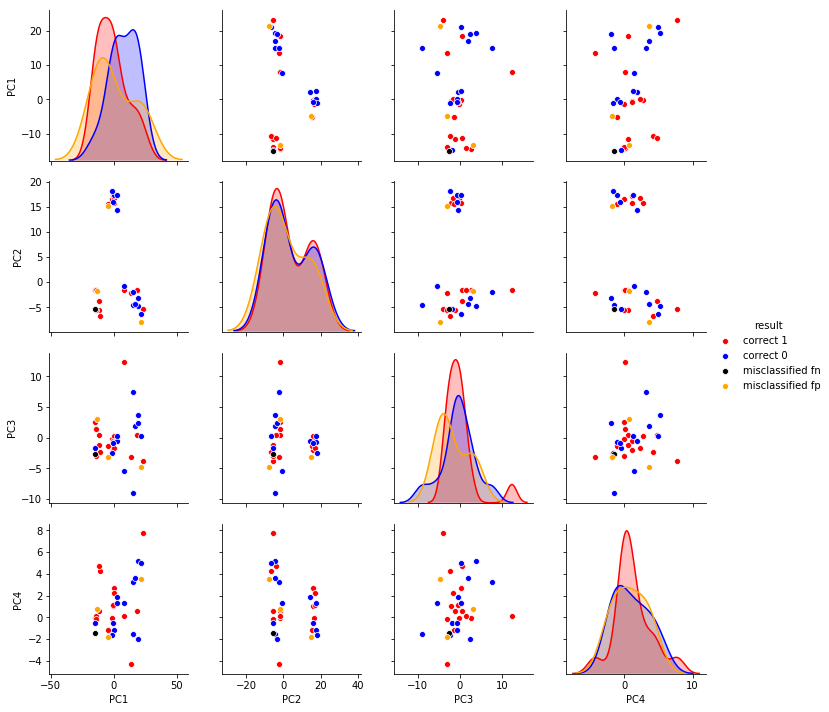

In [224]:
sns.pairplot(data=plot_df2,hue='result',vars=['PC1','PC2','PC3','PC4'], palette= ['red','blue','black','orange'])

In [225]:
plot_df2['result'].value_counts()

correct 1           16
correct 0           13
misclassified fp     3
misclassified fn     1
Name: result, dtype: int64

By looking at these plots also it is evident that there exists a clear seperation of classes (Positives and Negatives) only between the 1st 2 PCs.

### Conclusions

* In the first model I used recursive feature elimination to end up with best set of features where I used logistic regression and end up with 10 features with the best rankings but the statistical significance of the weights of the 10 attributes were very low.
* Then I build a method to randomply select attributes from the 10000 attributes and finally end up with best features where the number of features is less than or equal to 1/3 of the training instances.)
* In the third model I first generated the Principle Components and then fitted a logistic regression for the PCs.
* In the fourth model I first generated one Principle Component and fit a Randomforest and checked it's performance. Then I used Principle components that account for at least 90% of the total variance and finally used GridSerchCv to find the best parameters and fit a model.
* Following is the summary of the **"Accuracy Score"** and **"Recall of class 1 'Cancer' "** values I obtained for each model.I chose these criteria to choose the best model because it is important that none of the cancer remains undetected and it is also important to make the most accurate prediction possible as to whether a cancer exists.


|Model| Accuracy Score|Recall of class 1|
|--|--|--|
|Model 1: RFE(Logistic Regression)| 0.75 |0.65
|Model 2: Alternate RFE(Logistic Regression) | 0.69 |0.65|
|Model3: PCA(Logistic Regression)	 | 0.87 |0.82|
|Model4: 1 PCA(Random Forest)	 | 0.63 |0.53|
|Model5: 38 PCA(Random Forest)	 | 0.75 |0.53|
|Model6: 38 PCA(Random Forest with GridSearchCV)	 | 0.87 |0.94|